# Fraud Detection
The data set contains users activities at an e-commerce company website. The goal is to build a model to predict whether some user use the site to perform some illigal activities or not.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

In [2]:
fraud_df = pd.read_csv('Fraud_Data.csv')
ip_df = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
fraud_df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1


In [4]:
ip_df.head(2)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China


* the features we have are  
user_id  
signup_time  
purchase_time  
purchase_value  
device_id: unique code  
source: SEO/ads  
browser: chrome, opera  
Sex:   
Age:  
ip_address  
class label  
    

In [5]:
fraud_df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [7]:
fraud_df.shape

(151112, 11)

### Feature Engineering

* create time features

In [8]:
# convert string to timestamp
fraud_df['purchase_time']= pd.to_datetime(fraud_df['purchase_time']) 
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
# calculate the time difference in hours between signup and purchase
fraud_df['delay_time'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).astype('timedelta64[h]')

* Here I created a feature of time difference between signup and purchase

* create country column

In [9]:
def find_country(df,ip):
    '''
    :param1: ip_df
    :ip: ip address for lookup
    :return: country or None if cannot find 
    '''
    tmp_df = df.copy()
    country = tmp_df[(tmp_df['lower_bound_ip_address']<=ip) & (tmp_df['upper_bound_ip_address']>=ip)]
    #print country.head(2)
    
    if country.empty:
        return None
        
    else:
        return country['country'].values[0]
# add the country column
fraud_df['country']=fraud_df['ip_address'].apply(lambda x: find_country(ip_df,x))

# for countries not in the ip-country table, create label others
fraud_df['country'].fillna('others',inplace=True)

# find top 50 countries that have most fraud, and makes a list for country names
top_countries = fraud_df[['country','class']].groupby('country',as_index=False).sum()\
                .sort_values('class',ascending=False)['country'].head(50)
top_countries_list = set(top_countries.values)

# Only keep the top 50 country names.
fraud_df['high_risk_country'] = fraud_df['country'].apply(lambda x: x if x in top_countries_list else 'low')

* I also tried to convert the timestamp to local time using timezone data (https://timezonedb.com/download).

In [11]:
country_df = pd.read_csv('/Users/Wei.Zhao/Documents/2017_INSIGHT/Interview code prepare/data challenges/Fraud/timezonedb/country.csv',names = ['country_code','country'])
timezone_df = pd.read_csv('/Users/Wei.Zhao/Documents/2017_INSIGHT/Interview code prepare/data challenges/Fraud/timezonedb/timezone.csv',names = ["zone_id","abbreviation","time_start","gmt_offset","dst"])
zone_df = pd.read_csv('/Users/Wei.Zhao/Documents/2017_INSIGHT/Interview code prepare/data challenges/Fraud/timezonedb/zone.csv',names = ["zone_id","country_code","zone_name"])

In [12]:
timezone_df['gmt_hour'] = timezone_df['gmt_offset'].apply(lambda x:x/3600)

* For country that have multiple time zones, I'll use average gmt offset.

In [13]:
tz_tmp = timezone_df.groupby('zone_id').agg({'gmt_hour':{'gmt_hour_avg':'mean'}})
tz_tmp.columns = tz_tmp.columns.get_level_values(1)
tz_tmp.reset_index(inplace=True)

In [14]:
zone_df = zone_df.merge(tz_tmp,on='zone_id')

In [15]:
country_tz = country_df.merge(zone_df,on='country_code')

* Some country names in the timezone table do not match the country names in the dataset, I manually corrected

In [16]:
name_correction=dict(
                        {'Korea Republic of':'South Korea',
                         'Taiwan; Republic of China (ROC)':'Taiwan',
                         'Russian Federation':'Russia',
                         'Iran (ISLAMIC Republic Of)':'Iran',
                         'Syrian Arab Republic':'Saudi Arabia',
                         'European Union':'Germany',
                         'Viet Nam':'Vietnam',
                         'Moldova Republic of':'Moldova',
                         'Croatia (LOCAL Name: Hrvatska)':'Croatia',
                         'Namibia':'Namibia',
                         'Libyan Arab Jamahiriya':'Chad',#cannot find the country
                         'Slovakia (SLOVAK Republic)':'Slovakia',
                         'Bosnia and Herzegowina':'Bosnia and Herzegovina',
                         "Cote D'ivoire":'Ivory Coast',
                         'Virgin Islands (U.S.)':'British Virgin Islands',
                         'Congo':'Democratic Republic of the Congo',
                         'Palestinian Territory Occupied':'Palestinian Territory',
                         'Brunei Darussalam':'Brunei',
                         'Macau':'China',
                         'Tanzania United Republic of':'Tanzania',
                         'Congo The Democratic Republic of The':'Democratic Republic of the Congo',
                         'Curacao':'CuraÃ§ao',
                         "Lao People's Democratic Republic":'Laos',
                         'Bonaire; Sint Eustatius; Saba':'Sint Maarten'})
nonmatch_list = set(name_correction.keys())

def match_name(cname):
    if cname in nonmatch_list:
        return name_correction[cname]
    else:
        return cname
fraud_df['country'] = fraud_df['country'].apply(lambda x: match_name(x))

In [ ]:
# This is the code to find out any non-match country names
'''
c = fraud_df[['country']].copy()
c.drop_duplicates(subset='country',inplace=True)
country_timezone = c.merge(country_tz,on='country',how='left')
index_null = pd.isnull(country_timezone).any(1).nonzero()[0]
country_timezone.iloc[index_null]
'''

In [17]:
fraud_df = fraud_df.merge(country_tz[['country','gmt_hour_avg']],on='country',how='left')
fraud_df.fillna(0.0,inplace=True)

In [18]:
# Adjust signup_time, purchase_time to gmt offset
fraud_df['signup_time'] = fraud_df['signup_time']+pd.to_timedelta(fraud_df['gmt_hour_avg'],unit='h')
fraud_df['purchase_time'] = fraud_df['purchase_time']+pd.to_timedelta(fraud_df['gmt_hour_avg'],unit='h')

In [19]:
# extract the day of week for signup and purchase
fraud_df['signup_date'] = fraud_df['signup_time'].dt.weekday_name
fraud_df['purchase_date'] = fraud_df['purchase_time'].dt.weekday_name
#extract the hour of the day for signup and purchase
fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
#extract the week of year for signup and purchase
fraud_df['signup_week'] = fraud_df['signup_time'].dt.week
fraud_df['purchase_week'] = fraud_df['purchase_time'].dt.week

In [ ]:
#  Ideally, for each ip address, I can use the code below to get latitude and longitude, and therefore gmt offset precisely.
#  But I need more than 10 hours to query every ip address
'''
import requests
def Int2IP(ipnum):
    o1 = int(ipnum/16777216) %256
    o2 = int(ipnum/65536) %256
    o3 = int(ipnum/256)%256
    o4 = int(ipnum) %256
    return '%s.%s.%s.%s' %(o1,o2,o3,o4)

def meta_ip(ipnum):
    ip = Int2IP(ipnum)
    url = 'http://freegeoip.net/json/'+ip
    r = requests.get(url)
    js = r.json()
    return 
list(js.items())
'''

* I would also assume that people perform fault transaction on single device and/or ip address multiple times.

In [20]:
# count the times that device id were used for purchase
device_tmp = fraud_df.groupby('device_id').agg({'user_id':{'device_id_count':'count'}})
device_tmp.columns = device_tmp.columns.get_level_values(1)
device_tmp.reset_index(inplace=True)
# count the times that ip address were used for purchase.
ip_tmp = fraud_df.groupby('ip_address').agg({'user_id':{'ip_address_count':'count'}})
ip_tmp.columns = ip_tmp.columns.get_level_values(1)
ip_tmp.reset_index(inplace=True)

In [21]:
fraud_df = fraud_df.merge(device_tmp, on='device_id',how='left').merge(ip_tmp,on='ip_address',how='left')

In [22]:
print "The unique number of devices is :%d" %(fraud_df.device_id.nunique())
print "the total number of user id is :%d" %(fraud_df.user_id.nunique())

The unique number of devices is :137956
the total number of user id is :151112


* user_id is unique, no two users have the same id

### Visualization of categorical features

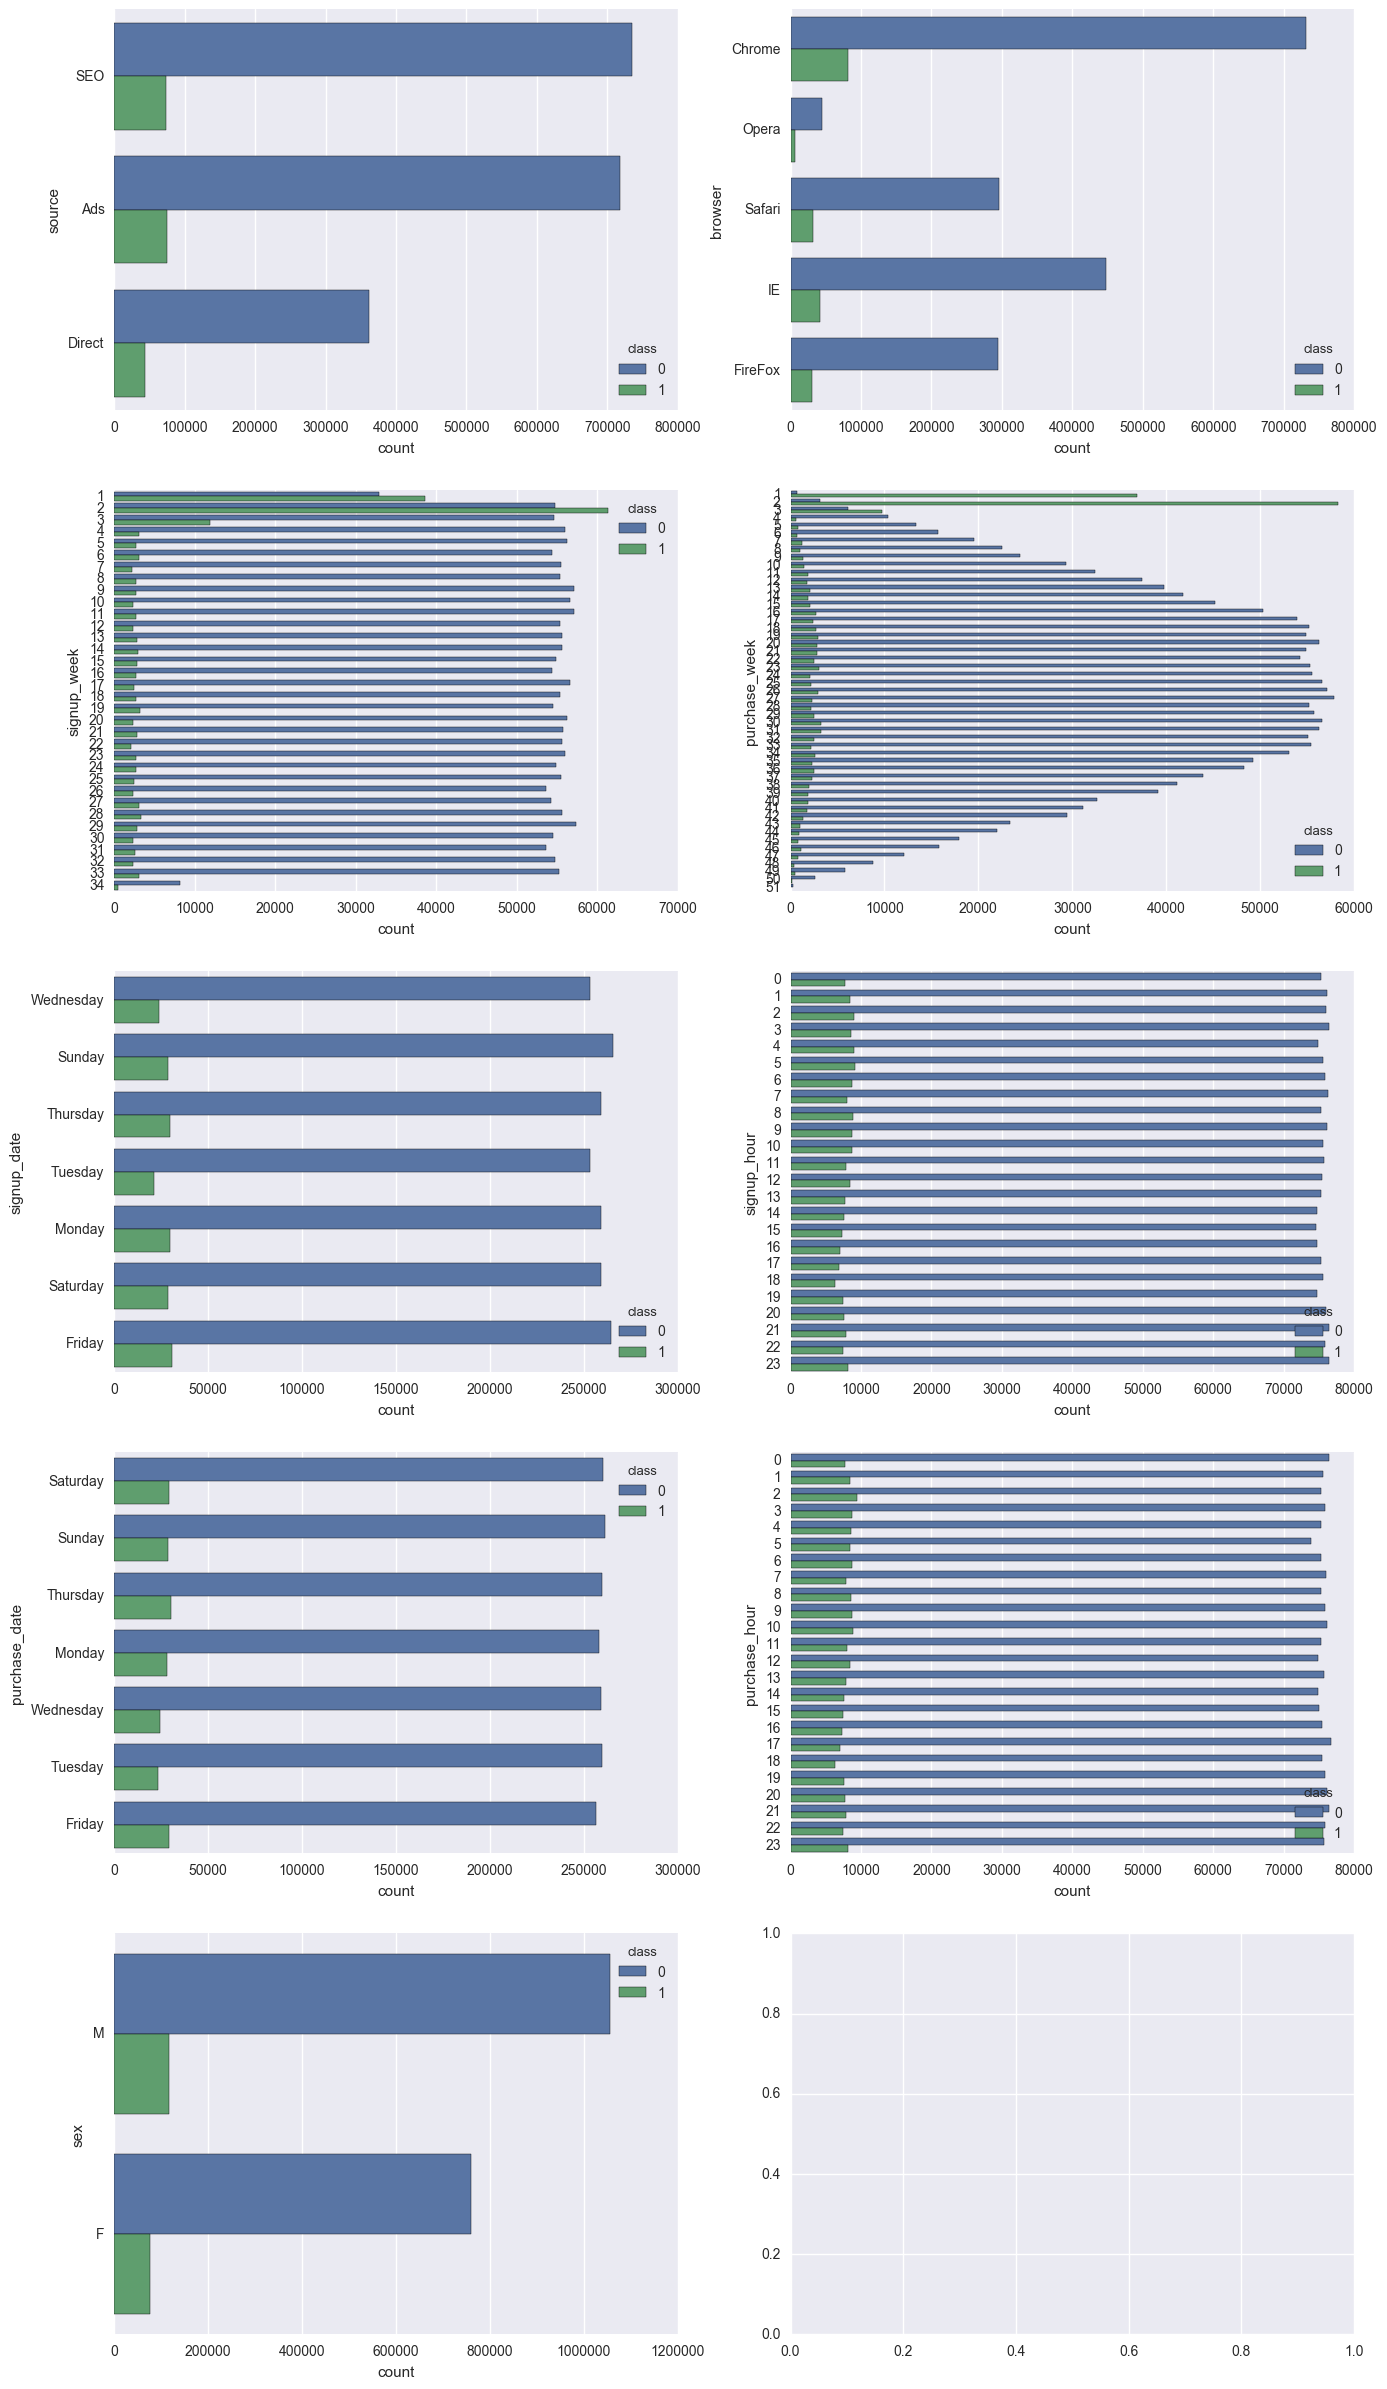

In [24]:
cate_features = ['source','browser','signup_week','purchase_week','signup_date','signup_hour','purchase_date','purchase_hour','sex']
f, axes = plt.subplots(5, 2,figsize=(16,30))
for i,one in enumerate(cate_features):
    col = i % 2
    row = i//2
    ax_curr = axes[row, col]
    sns.countplot(y=one, hue="class", data=fraud_df, ax=ax_curr)
   

* Visualization of Numerical Features

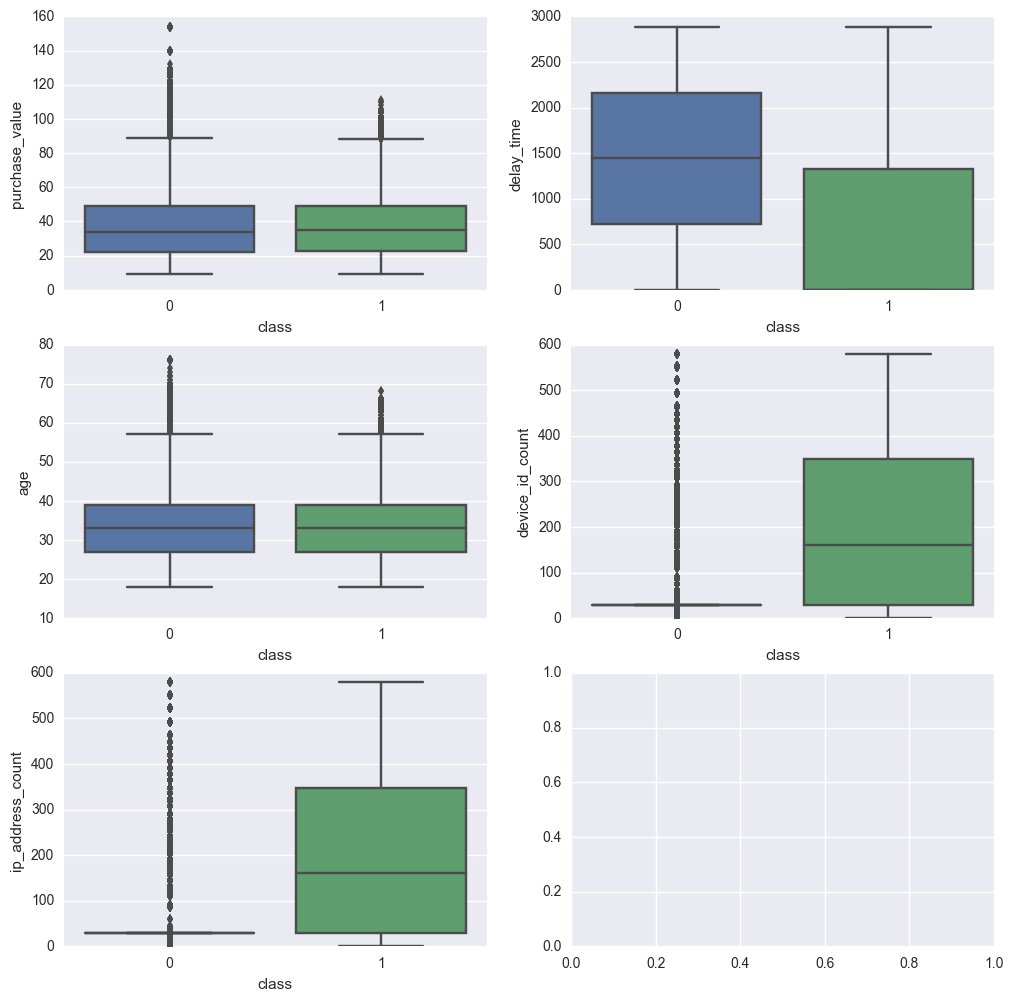

In [25]:
num_features = ['purchase_value','delay_time','age','device_id_count','ip_address_count']

f,axes = plt.subplots(3,2,figsize=(12,12))
for i,one in enumerate(num_features):
    row = i//2
    column = i%2
    ax_curr = axes[row,column]
    sns.boxplot(x='class', y = one, data=fraud_df, ax=ax_curr)

Features might be import include: the time difference between signup and purchase, the times that a given ip address was use, as well as the time a given device is used.

In [26]:
columns_convert = ['source','browser','sex','high_risk_country','signup_date','purchase_date']
fraud_df[columns_convert].head(5)

,source,browser,sex,high_risk_country,signup_date,purchase_date
0,SEO,Chrome,M,Japan,Wednesday,Saturday
1,Ads,Chrome,F,United States,Sunday,Sunday
2,Ads,Chrome,F,United States,Sunday,Sunday
3,Ads,Chrome,F,United States,Sunday,Sunday
4,Ads,Chrome,F,United States,Sunday,Sunday


In [27]:
# change the categorical variables to numerical variables
num_df = pd.get_dummies(fraud_df[columns_convert],prefix = columns_convert)
columns_num = ['delay_time','purchase_value','age','device_id_count','ip_address_count','signup_hour','signup_week','purchase_hour','purchase_week']
data_df = fraud_df[columns_num].join(num_df)
feature_columns = columns_num + num_df.columns.tolist()
target_column = 'class'

In [28]:
data_df.to_pickle('cleaned_data.pkl')
fraud_df['class'].to_pickle('label.pkl')